# 2D Data (Linear)

## Library Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## Generate Data (Linear)

In [ ]:
np.random.seed(24)

amt = 300
cov = [[1, 0], [0, 1]]
centerA = [0, 0]
centerB = [5, 5]  # clear margin
# centerB = [4, 4]  # some support vectors within margins (still no error)
# centerB = [3, 3]  # some misclassified

clusterA = np.random.multivariate_normal(centerA, cov, amt)
clusterB = np.random.multivariate_normal(centerB, cov, amt)

## Generate Data (Non Linear)

In [ ]:
np.random.seed(24)

amt = 125
cov = [[2, 0], [0, 2]]
centerA = [0, 0]
centerB_a = [10, 0]
centerB_b = [-10, 0]

clusterA = np.random.multivariate_normal(centerA, cov, amt)
clusterB_a = np.random.multivariate_normal(centerB_a, cov, amt)
clusterB_b = np.random.multivariate_normal(centerB_b, cov, amt)
clusterB = np.append(clusterB_a, clusterB_b, axis=0)

## Prepare Data

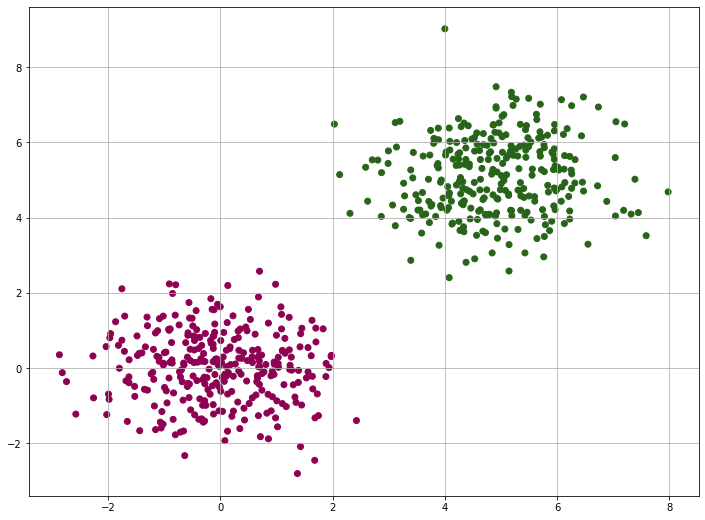

In [ ]:
from sklearn.model_selection import train_test_split

sizeA = len(clusterA)
sizeB = len(clusterB)

X = np.append(clusterA, clusterB, axis=0)
Y = np.append(np.zeros((sizeA, 1)), 2 * np.ones((sizeB, 1)), axis=0)
Y = np.reshape(Y, (sizeA + sizeB,))

X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.4)

plt.figure(figsize=(12, 9)) ; plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y, cmap="PiYG");

## Train SVM

In [ ]:
from sklearn.svm import SVC

### Linear

In [ ]:
model = SVC(kernel="linear")
model.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
model.score(x_test, y_test)

1.0

### Non Linear

In [ ]:
model = SVC(kernel="poly", degree=2)
model.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
model.score(x_test, y_test)

1.0

## Visualize results

In [ ]:
# plot function from the following resource
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
def plot_svc_decision_function(model):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    supp = model.support_vectors_
    ax.scatter(supp[:,0], supp[:,1], s=100, facecolors="none", edgecolors='k')

    ax.set_xlim(xlim); ax.set_ylim(ylim)

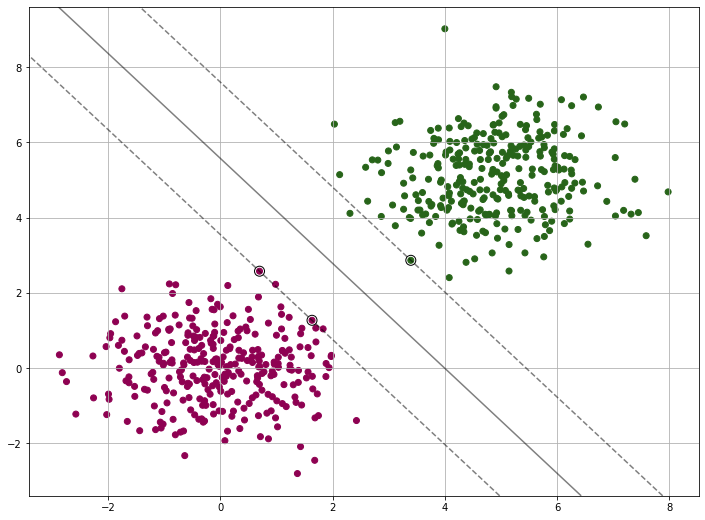

In [ ]:
plt.figure(figsize=(12, 9)) ; plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y, cmap="PiYG")
plot_svc_decision_function(model)

# MNIST

## Library Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Preparing Data

### Importing

In [ ]:
## mnist
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (x_test, y_test) = mnist.load_data()

# prepare for scikit models
X_train = np.array([x.flatten() for x in X_train])
x_test = np.array([x.flatten() for x in x_test])

11493376/11490434 [==============================] - 0s 0us/step


### Deskewing

In [ ]:
# the code in this block isn't mine!
# it comes from https://fsix.github.io/mnist/Deskewing.html#Deskewing

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import affine_transform, map_coordinates

def moments(image):
    assert len(image.shape) == 2
    c0, c1 = np.mgrid[:image.shape[0],:image.shape[1]]
    totalImage = np.sum(image)
    m0 = np.sum(c0*image)/totalImage
    m1 = np.sum(c1*image)/totalImage
    m00 = np.sum((c0-m0)**2*image)/totalImage
    m11 = np.sum((c1-m1)**2*image)/totalImage
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage
    mu_vector = np.array([m0,m1])
    covariance_matrix = np.array([[m00,m01],[m01,m11]])
    return mu_vector, covariance_matrix

def deskew(image):
    c, v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return affine_transform(image,affine,offset=offset)

def elastic_transform(image, alpha, sigma):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape) == 2

    random_state = np.random.RandomState(42)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [ ]:
# combine above methods into a single preprocess pipeline
def preprocess(dataset, normalize=True, apply_deskew=True, apply_elastic=True):
    # make sure our X matrix is in numpy form
    if isinstance(dataset, pd.DataFrame):
        X = dataset.to_numpy()
    elif not isinstance(dataset, np.ndarray):
        X = np.array(dataset)
    else:
        X = dataset.copy()

    if normalize:
        # normalize to [0,1]
        X = X / 255.0
    if apply_deskew:
        # apply deskewing
        X = [deskew(x.reshape(28,28)) for x in X]
    if apply_elastic:
        # additionally apply elastic transformations
        X = [elastic_transform(x.reshape(28,28), 34, 4) for x in X]
    
    # flatten back from (28,28) to (784,1)
    return np.array([x.flatten() for x in X])

In [ ]:
X_train_prepared = preprocess(X_train)

In [ ]:
x_test_prepared = preprocess(x_test)

### PCA

In [ ]:
from sklearn.decomposition import PCA

# PCA dimensionality reduction
# keep 90% of orginal variance
pca = PCA(0.9, random_state=42)
pca.fit(X_train_prepared)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_train_pca = pca.transform(X_train_prepared)

In [ ]:
x_test_pca = pca.transform(x_test_prepared)

In [ ]:
X_train_pca.shape

(60000, 47)

## Neighbor models

### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn1 = KNeighborsClassifier(1, n_jobs=-1)
knn1.fit(X_train_pca, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
knn1.score(x_test_pca, y_test)

0.983

In [ ]:
knn3 = KNeighborsClassifier(3, n_jobs=-1)
knn3.fit(X_train_pca, Y_train);

In [ ]:
knn3.score(x_test_pca, y_test)

0.9829

### Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid

nc = NearestCentroid()
nc.fit(X_train_pca, Y_train)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [ ]:
nc.score(x_test_pca, y_test)

0.856

## Support Vector Machines

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['linear', 'poly', 'rbf']
}

svc = svm.SVC(shrinking=True, cache_size=1000, random_state=42)
grid = GridSearchCV(svc, param_grid, n_jobs=-1, verbose=1)
grid.fit(X_train_pca, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=1000,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [ ]:
clf = grid.best_estimator_
grid.best_params_

{'kernel': 'rbf'}

In [ ]:
clf.score(x_test_pca, y_test)

0.9873

In [ ]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.571876,0.563547,5.375713,0.102577,linear,{'kernel': 'linear'},0.964250,0.963333,0.960917,0.960250,0.965083,0.962767,0.001879,3
1,35.497509,0.766581,8.569853,0.022061,poly,{'kernel': 'poly'},0.986417,0.986750,0.985167,0.983333,0.985667,0.985467,0.001203,2
2,28.882338,1.091101,10.097705,0.886212,rbf,{'kernel': 'rbf'},0.986583,0.988083,0.985750,0.982667,0.985917,0.985800,0.001770,1


## Odd vs Even Numbers

### Transforming

In [ ]:
def transform(Y_train, y_test):
    assert type(Y_train) == np.ndarray
    assert type(y_test) == np.ndarray

    Y_train_parity = Y_train.copy()
    y_test_parity = y_test.copy()

    Y_train_parity[Y_train_parity % 2 == 0] = 0
    Y_train_parity[Y_train_parity % 2 == 1] = 1

    y_test_parity[y_test_parity % 2 == 0] = 0
    y_test_parity[y_test_parity % 2 == 1] = 1

    return Y_train_parity, y_test_parity

In [ ]:
Y_train_parity, y_test_parity = transform(Y_train, y_test)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn1 = KNeighborsClassifier(1, n_jobs=-1)
knn1.fit(X_train_pca, Y_train_parity)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
knn1.score(x_test_pca, y_test_parity)

0.991

In [ ]:
knn3 = KNeighborsClassifier(3, n_jobs=-1)
knn3.fit(X_train_pca, Y_train_parity)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
knn3.score(x_test_pca, y_test_parity)

0.9917

### Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid

nc = NearestCentroid()
nc.fit(X_train_pca, Y_train_parity)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [ ]:
nc.score(x_test_pca, y_test_parity)

0.7998

### SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1, 10],
}

svc = svm.SVC(shrinking=True, cache_size=1000, random_state=42)
grid = GridSearchCV(svc, param_grid, n_jobs=-1, verbose=1)
grid.fit(X_train_pca, Y_train_parity)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 59.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=1000,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10], 'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [ ]:
clf = grid.best_estimator_
grid.best_params_

{'C': 10, 'kernel': 'rbf'}

In [ ]:
clf.score(x_test_pca, y_test_parity)

0.9944

In [ ]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,194.317124,3.693252,8.543858,0.629899,1,linear,"{'C': 1, 'kernel': 'linear'}",0.925417,0.918333,0.917167,0.924250,0.926500,0.922333,0.003827,5
1,29.547233,1.067537,4.029371,0.088452,1,poly,"{'C': 1, 'kernel': 'poly'}",0.989833,0.989083,0.988083,0.990583,0.989750,0.989467,0.000839,3
2,28.902056,0.469827,4.666685,0.069369,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.990083,0.990917,0.988583,0.990167,0.990417,0.990033,0.000781,2
3,1012.912106,90.972008,7.953531,1.070713,10,linear,"{'C': 10, 'kernel': 'linear'}",0.925167,0.918500,0.917250,0.924083,0.926500,0.922300,0.003714,6
4,26.192512,0.498807,2.560303,0.022721,10,poly,"{'C': 10, 'kernel': 'poly'}",0.990000,0.988917,0.988167,0.988917,0.989250,0.989050,0.000593,4
5,27.161686,0.631755,3.462714,0.046947,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.991333,0.993250,0.990750,0.991167,0.992167,0.991733,0.000887,1


## Visualizing Results

In [ ]:
def show_test_output(model, i, silent=False):
  if not silent:
    plt.figure()
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')

  label = y_test_parity[i]
  predicted_class = model.predict(np.array([x_test_pca[i]]))

  if not silent:
    print("Test Sample #%d" % i)
    print("Actual:", "odd" if label else "even")
    print("Predicted:", "odd" if predicted_class else "even")

  return label == predicted_class

Test Sample #151
Actual: odd
Predicted: even


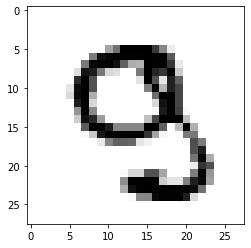

In [ ]:
for i in range(len(x_test_pca)):
  correct = show_test_output(clf, i, silent=True)
  if not correct:
    show_test_output(clf, i)
    break

Test Sample #0
Actual: odd
Predicted: odd


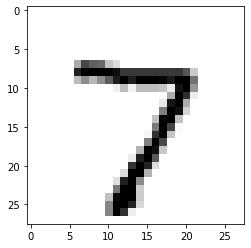

In [ ]:
show_test_output(clf, 0);